## Electronic Health Records A3

- GroupA3 ID: D
- Student 1 Name: Bet Baradají
- Student 2 Name: Jens Lagemann

### Set up

In [1]:
#install.packages('ReIns')

In [2]:
library(dplyr)
library(tidyr)
library(tibble)
library(lubridate)
library(readr)
library(stringr)
library(ggplot2)
library(data.table)
library(odbc)
library(RMariaDB)
library(survival)
library(ReIns)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Attaching package: ‘lubridate’


The following objects are masked from ‘package:base’:

    date, intersect, setdiff, union



Attaching package: ‘data.table’


The following objects are masked from ‘package:lubridate’:

    hour, isoweek, mday, minute, month, quarter, second, wday, week,
    yday, year


The following objects are masked from ‘package:dplyr’:

    between, first, last




In [3]:
con <- dbConnect(
  drv = RMariaDB::MariaDB(),
  username = "jensalexander.lagemann",
  password = "w7mA",
  host = "10.112.11.116",
  #host = "tanisjones.ddns.net",
  dbname = "mimiciiiv14",
  port = 3306
)

### Identifying subjects
For the exploratory study of the effect of diabetes mellitus on co-occuring pathologies, we first need to identify the subjects in our cohort. For this we identify every subject with a diagnosis using the ICD9 code 25000: 
"Diabetes mellitus without mention of complication, type II or unspecified type, not stated as uncontrolled".
This is the most common DM diagnosis relating to type II, which is significantly more common than type I in the data.


In [4]:
sql <- "
SELECT di.ICD9_CODE, COUNT(DISTINCT(di.SUBJECT_ID)) as n
FROM DIAGNOSES_ICD di 
WHERE di.ICD9_CODE  LIKE '25%'
GROUP BY di.ICD9_CODE
ORDER BY n DESC;"
dbGetQuery(con, sql) %>% head(5)

ICD9_CODE n   
1 25000     7370
2 25060      887
3 25040      745
4 2536       473
5 25002      431

To create our cohort, we select every subject that has had a diagnosis of 25000. This is not a perfect selection process. We might lose out on some subjects that have received other diagnosis related to DMII, but not the general 25000 code. This code also includes cases of unspecified type, so there might be subjects who have received diagnosis related to type I in other admissions. 

In [5]:
sql_cohort <- "
SELECT p.SUBJECT_ID, p.GENDER, p.DOB, p.DOD
FROM PATIENTS p
WHERE p.SUBJECT_ID IN 
	(SELECT DISTINCT(di.SUBJECT_ID)
	FROM DIAGNOSES_ICD di 
	WHERE di.ICD9_CODE LIKE '25000')
"

In [6]:
subject_dm <- dbGetQuery(con, sql_cohort)

In [7]:
subject_dm %>% head(10)

SUBJECT_ID GENDER DOB        DOD       
1  12706      F      2049-09-30 2113-01-25
2  13144      M      2137-07-10 2202-01-03
3  24568      F      2114-11-27 <NA>      
4  32156      F      2098-03-27 <NA>      
5    378      M      2038-05-20 <NA>      
6   1054      M      2078-07-15 2157-01-08
7   1903      M      2121-07-19 <NA>      
8   2116      F      2074-11-20 2138-03-01
9   2361      M      2036-10-08 2108-08-23
10  4211      M      2045-02-18 2129-03-21

Extracting common comorbidities of the diabetes population

In [8]:
sql_com <- "
SELECT di.ICD9_CODE, 
    t.LONG_TITLE, 
    COUNT(DISTINCT(di.SUBJECT_ID)) as n_subj, 
    COUNT(DISTINCT(di.SUBJECT_ID))/7370 as prevalence
FROM DIAGNOSES_ICD di 
INNER JOIN (
	SELECT did.ICD9_CODE, did.LONG_TITLE
	FROM D_ICD_DIAGNOSES did
	) as t
ON di.ICD9_CODE = t.ICD9_CODE
WHERE di.SUBJECT_ID IN 
	(SELECT DISTINCT(di.SUBJECT_ID)
	FROM DIAGNOSES_ICD di 
	WHERE di.ICD9_CODE LIKE '25000')
AND di.ICD9_CODE NOT LIKE '25000'
GROUP BY ICD9_CODE 
ORDER BY n_subj DESC;
"
sub_com <- dbGetQuery(con, sql_com)

In [9]:
sub_com %>% head(10)

ICD9_CODE LONG_TITLE                                         n_subj
1  4019      Unspecified essential hypertension                 4583  
2  41401     Coronary atherosclerosis of native coronary artery 3165  
3  4280      Congestive heart failure, unspecified              2748  
4  42731     Atrial fibrillation                                2483  
5  2724      Other and unspecified hyperlipidemia               2198  
6  5849      Acute kidney failure, unspecified                  1994  
7  51881     Acute respiratory failure                          1506  
8  2720      Pure hypercholesterolemia                          1473  
9  5990      Urinary tract infection, site not specified        1406  
10 2859      Anemia, unspecified                                1215  
   prevalence
1  0.6218    
2  0.4294    
3  0.3729    
4  0.3369    
5  0.2982    
6  0.2706    
7  0.2043    
8  0.1999    
9  0.1908    
10 0.1649

Looking at prevalence of those diseases in the overall population, excluding our diabetes cohort
(4019, 41401, 4280, 42731, 2724, 5849, 51881, 2720, 5990, 2859)

In [10]:
sql_npop <- "
SELECT COUNT(DISTINCT(di.SUBJECT_ID))
FROM DIAGNOSES_ICD di 
WHERE di.SUBJECT_ID NOT IN 
	(SELECT DISTINCT(di.SUBJECT_ID)
	FROM DIAGNOSES_ICD di 
	WHERE di.ICD9_CODE LIKE '25000')
"
dbGetQuery(con, sql_npop) %>% head

COUNT(DISTINCT(di.SUBJECT_ID))
1 39150

In [11]:
sql_pop <- "
SELECT di.ICD9_CODE,
    COUNT(DISTINCT(di.SUBJECT_ID)) as n_subj,
    COUNT(DISTINCT(di.SUBJECT_ID))/39150 as prevalence
FROM DIAGNOSES_ICD di 
WHERE di.SUBJECT_ID NOT IN (SELECT DISTINCT(di.SUBJECT_ID)
    FROM DIAGNOSES_ICD di 
    WHERE di.ICD9_CODE LIKE '25000')
    AND di.ICD9_CODE IN (4019, 41401, 4280, 42731, 2724, 5849, 51881, 2720, 5990, 2859)
GROUP BY di.ICD9_CODE
ORDER BY n_subj DESC;
"
df_pop <- dbGetQuery(con, sql_pop)

In [12]:
df_pop %>% head(10)

ICD9_CODE n_subj prevalence
1  4019      13030  0.3328    
2  42731      7788  0.1989    
3  41401      7610  0.1944    
4  4280       7095  0.1812    
5  5849       5693  0.1454    
6  2724       5267  0.1345    
7  51881      5213  0.1332    
8  5990       4373  0.1117    
9  2720       3862  0.0986    
10 2859       3778  0.0965

In [13]:
colnames(df_pop) <- c("ICD9_CODE", "h_subj", "h_prev")

In [14]:
df_compare <- merge(sub_com, df_pop, by = "ICD9_CODE")
df_compare[order(df_compare$n_subj, decreasing= TRUE),] 

ICD9_CODE LONG_TITLE                                         n_subj
4  4019      Unspecified essential hypertension                 4583  
5  41401     Coronary atherosclerosis of native coronary artery 3165  
7  4280      Congestive heart failure, unspecified              2748  
6  42731     Atrial fibrillation                                2483  
2  2724      Other and unspecified hyperlipidemia               2198  
9  5849      Acute kidney failure, unspecified                  1994  
8  51881     Acute respiratory failure                          1506  
1  2720      Pure hypercholesterolemia                          1473  
10 5990      Urinary tract infection, site not specified        1406  
3  2859      Anemia, unspecified                                1215  
   prevalence h_subj h_prev
4  0.6218     13030  0.3328
5  0.4294      7610  0.1944
7  0.3729      7095  0.1812
6  0.3369      7788  0.1989
2  0.2982      5267  0.1345
9  0.2706      5693  0.1454
8  0.2043      5213  0.1332
1  0.1999      3862  0.0986
10 0.1908      4373  0.1117
3  0.1649      3778  0.0965

It is visible that the most common comorbidities present in the diabetes population are much more common than in the general population, most of them roughly by a factor of 2.

In [15]:
sql_adm <- "
SELECT d.ICD9_CODE,
    a.SUBJECT_ID,
    a.HADM_ID,
    DATEDIFF(a.DISCHTIME , a.ADMITTIME) as LOS,
    a.DEATHTIME,
    a.ETHNICITY,
    pat.GENDER,
    DATEDIFF(a.ADMITTIME, pat.DOB)/365 AS AGE_AT_ADM,
    a.INSURANCE,
    a.ADMISSION_TYPE
FROM ADMISSIONS a
INNER JOIN (SELECT di.HADM_ID, di.ICD9_CODE
    FROM DIAGNOSES_ICD di) d
ON a.HADM_ID = d.HADM_ID
INNER JOIN (SELECT p.SUBJECT_ID, p.GENDER, p.DOB
    FROM PATIENTS p) pat
ON a.SUBJECT_ID = pat.SUBJECT_ID
WHERE a.SUBJECT_ID IN (SELECT DISTINCT(di.SUBJECT_ID)
    FROM DIAGNOSES_ICD di 
    WHERE di.ICD9_CODE LIKE '25000') 
    AND d.ICD9_CODE IN (4019, 41401, 4280, 42731, 2724, 5849, 51881, 2720, 5990, 2859)
"
df_adm <- dbGetQuery(con, sql_adm)

In [16]:
sql_c_adm <- "
SELECT d.ICD9_CODE,
    a.SUBJECT_ID,
    a.HADM_ID,
    DATEDIFF(a.DISCHTIME , a.ADMITTIME) as LOS,
    a.DEATHTIME,
    a.ETHNICITY,
    pat.GENDER,
    DATEDIFF(a.ADMITTIME, pat.DOB)/365 AS AGE_AT_ADM,
    a.INSURANCE,
    a.ADMISSION_TYPE
FROM ADMISSIONS a
INNER JOIN (SELECT di.HADM_ID, di.ICD9_CODE
    FROM DIAGNOSES_ICD di) d
ON a.HADM_ID = d.HADM_ID
INNER JOIN (SELECT p.SUBJECT_ID, p.GENDER, p.DOB
    FROM PATIENTS p) pat
ON a.SUBJECT_ID = pat.SUBJECT_ID
WHERE a.SUBJECT_ID NOT IN (SELECT DISTINCT(di.SUBJECT_ID)
    FROM DIAGNOSES_ICD di 
    WHERE di.ICD9_CODE LIKE '25000') 
    AND d.ICD9_CODE IN (4019, 41401, 4280, 42731, 2724, 5849, 51881, 2720, 5990, 2859)
"
df_c_adm <- dbGetQuery(con, sql_c_adm)

In [17]:
# Mark the admissions according to diabetic population and control population
df_adm$status = 1
df_c_adm$status = 0
# Combine the data frames
admissions <- rbind(df_adm, df_c_adm)
# Converting variables to factor to make for easier analysis
admissions$status <- as.factor(admissions$status)
admissions$GENDER <- as.factor(admissions$GENDER)
admissions$AGE_AT_ADM <- as.integer(admissions$AGE_AT_ADM)
admissions %>% head(10)


ICD9_CODE SUBJECT_ID HADM_ID LOS DEATHTIME ETHNICITY GENDER AGE_AT_ADM
1  41401     13         143045   7  <NA>      WHITE     F      39        
2  4019      13         143045   7  <NA>      WHITE     F      39        
3  2720      13         143045   7  <NA>      WHITE     F      39        
4  41401     20         157681   5  <NA>      WHITE     F      75        
5  2724      20         157681   5  <NA>      WHITE     F      75        
6  4019      20         157681   5  <NA>      WHITE     F      75        
7  5849      21         109451  13  <NA>      WHITE     M      87        
8  4280      21         109451  13  <NA>      WHITE     M      87        
9  42731     21         109451  13  <NA>      WHITE     M      87        
10 41401     21         109451  13  <NA>      WHITE     M      87        
   INSURANCE ADMISSION_TYPE status
1  Medicaid  EMERGENCY      1     
2  Medicaid  EMERGENCY      1     
3  Medicaid  EMERGENCY      1     
4  Medicare  ELECTIVE       1     
5  Medicare  ELECTIVE       1     
6  Medicare  ELECTIVE       1     
7  Medicare  EMERGENCY      1     
8  Medicare  EMERGENCY      1     
9  Medicare  EMERGENCY      1     
10 Medicare  EMERGENCY      1

### Analysis of population

In [18]:
subjects <- admissions %>% distinct(SUBJECT_ID, .keep_all = TRUE)

subjects %>%
    group_by(status) %>%
    mutate(total=n_distinct(SUBJECT_ID)) %>%
    group_by(GENDER, .add = TRUE) %>%
    summarise(n = n_distinct(SUBJECT_ID), ratio = n_distinct(SUBJECT_ID)/mean(total))

sub_age <- findInterval(subjects$AGE_AT_ADM, c(50, 60, 70, 80))
subjects$age_group <- as.factor(sub_age)

subjects %>%
    group_by(status) %>%
    mutate(total=n_distinct(SUBJECT_ID)) %>%
    group_by(age_group, .add = TRUE) %>%
    summarise(n = n_distinct(SUBJECT_ID), ratio = n_distinct(SUBJECT_ID)/mean(total))

subjects %>%
    group_by(status) %>%
    mutate(total=n_distinct(SUBJECT_ID)) %>%
    group_by(INSURANCE, .add = TRUE) %>%
    summarise(n = n_distinct(SUBJECT_ID), ratio = n_distinct(SUBJECT_ID)/mean(total))

admissions %>%
    group_by(SUBJECT_ID) %>%
    mutate(n_adm = n_distinct(HADM_ID)) %>%
    group_by(status) %>%
    summarise(mean_adm = mean(n_adm))

subjects %>%
    group_by(status) %>%
    mutate(total=n_distinct(SUBJECT_ID)) %>%
    group_by(ADMISSION_TYPE, .add = TRUE) %>%
    summarise(n = n_distinct(SUBJECT_ID), ratio = n_distinct(SUBJECT_ID)/mean(total))


`summarise()` has grouped output by 'status'. You can override using the
`.groups` argument.


status GENDER n     ratio    
1 0      F      10924 0.4390852
2 0      M      13955 0.5609148
3 1      F       3010 0.4262249
4 1      M       4052 0.5737751

`summarise()` has grouped output by 'status'. You can override using the
`.groups` argument.


status age_group n    ratio     
1  0      0         3939 0.15832630
2  0      1         4164 0.16737007
3  0      2         5205 0.20921259
4  0      3         5442 0.21873870
5  0      4         6129 0.24635235
6  1      0          452 0.06400453
7  1      1         1103 0.15618805
8  1      2         1866 0.26423110
9  1      3         2047 0.28986123
10 1      4         1594 0.22571509

`summarise()` has grouped output by 'status'. You can override using the
`.groups` argument.


status INSURANCE  n     ratio      
1  0      Government   592 0.023795169
2  0      Medicaid    1800 0.072350175
3  0      Medicare   14602 0.586920696
4  0      Private     7683 0.308814663
5  0      Self Pay     202 0.008119297
6  1      Government   121 0.017133956
7  1      Medicaid     460 0.065137355
8  1      Medicare    4686 0.663551402
9  1      Private     1761 0.249362787
10 1      Self Pay      34 0.004814500

status mean_adm
1 0      1.776640
2 1      2.439603

`summarise()` has grouped output by 'status'. You can override using the
`.groups` argument.


status ADMISSION_TYPE n     ratio     
1 0      ELECTIVE        3933 0.15808513
2 0      EMERGENCY      20209 0.81229149
3 0      NEWBORN           33 0.00132642
4 0      URGENT           704 0.02829696
5 1      ELECTIVE        1158 0.16397621
6 1      EMERGENCY       5698 0.80685358
7 1      URGENT           206 0.02917021

### Compare length of stay between comorbidities

Warning message:
“Removed 4428 rows containing non-finite values (stat_boxplot).”


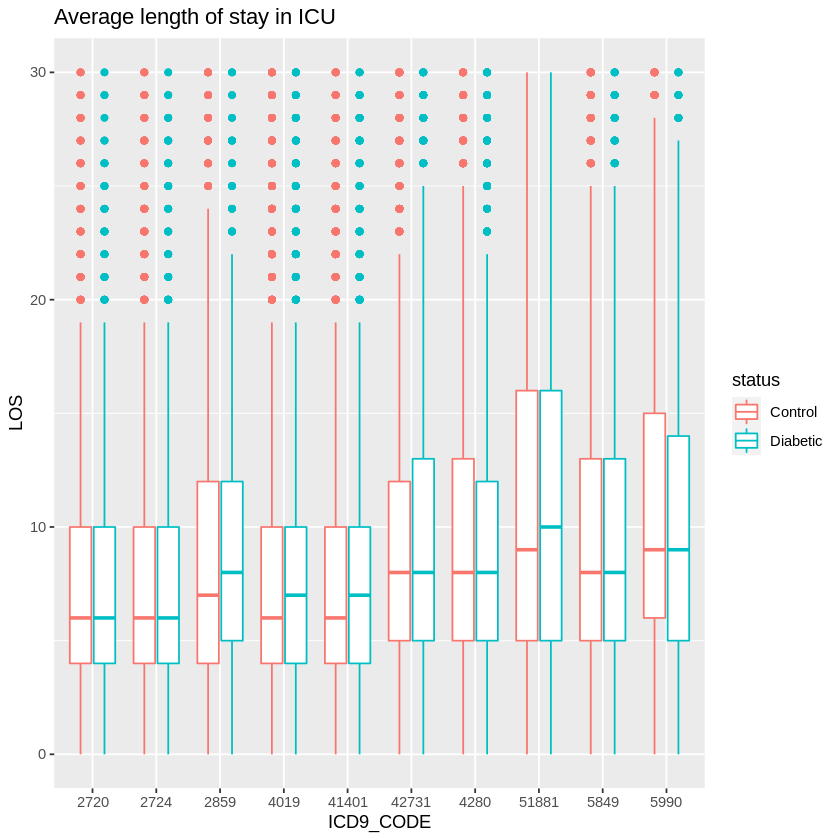

In [19]:
ggplot(data=admissions, aes(x = ICD9_CODE, y = LOS)) + 
    geom_boxplot(aes(color=status)) + 
    ylim(0,30) +
    ggtitle('Average length of stay in ICU') +
    scale_color_discrete(labels=c('Control', 'Diabetic'))

There does not seems to be a signficant difference in the distributions of the length of stays between the diabetic and non-diabetic population
### Comparison in LOS when the subject died

`summarise()` has grouped output by 'ICD9_CODE'. You can override using the
`.groups` argument.


ICD9_CODE status avg_los   n     mortality 
1  2720      0       8.160057  4236 0.07176582
2  2720      1       8.423259  1694 0.07378985
3  2724      0       8.204207  6038 0.07220934
4  2724      1       8.465686  2651 0.08147869
5  2859      0      10.239339  4056 0.08999014
6  2859      1      10.564863  1349 0.09710897
7  4019      0       8.928486 14998 0.09787972
8  4019      1       9.137217  5698 0.09775360
9  41401     0       8.597065  8586 0.07116236
10 41401     1       8.884695  3842 0.07339927
11 42731     0      11.230630  9419 0.15766005
12 42731     1      11.074950  3467 0.12892991
13 4280      0      11.558236  8912 0.15630610
14 4280      1      10.515837  4199 0.11740891
15 51881     0      14.814313  5687 0.31791806
16 51881     1      13.950276  1810 0.26298343
17 5849      0      12.295455  6556 0.21079927
18 5849      1      11.734296  2562 0.17135051
19 5990      0      14.348113  4849 0.12476799
20 5990      1      13.418523  1706 0.12192263

`summarise()` has grouped output by 'ICD9_CODE'. You can override using the
`.groups` argument.


ICD9_CODE status avg_los   n   
1  2720      0       8.825083  303
2  2720      1       9.508065  124
3  2724      0       8.905747  435
4  2724      1       8.586047  215
5  2859      0      11.123626  364
6  2859      1      12.615385  130
7  4019      0       8.428085 1467
8  4019      1       9.089928  556
9  41401     0       9.450820  610
10 41401     1       8.939502  281
11 42731     0      11.622896 1484
12 42731     1      10.470852  446
13 4280      0      12.445402 1392
14 4280      1      10.002033  492
15 51881     0      12.166574 1807
16 51881     1      11.543158  475
17 5849      0      11.482983 1381
18 5849      1      11.779043  438
19 5990      0      16.273179  604
20 5990      1      14.685990  207

Warning message:
“Removed 912 rows containing non-finite values (stat_boxplot).”


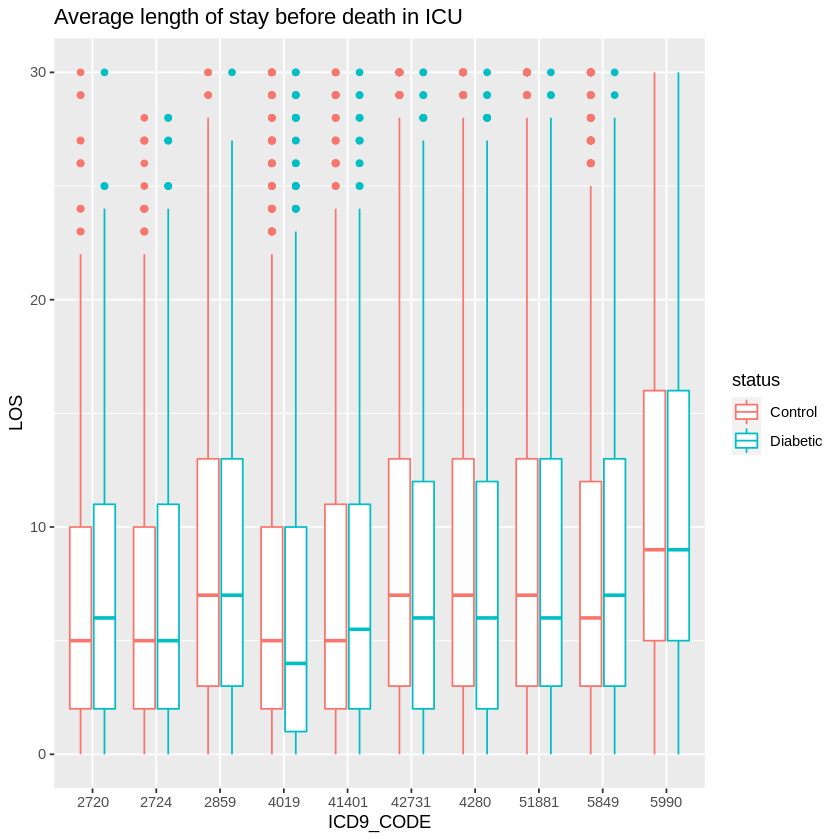

In [20]:
# drop all na, therefore only retaining rows with a deathtime
deaths <- admissions %>% na.omit
admissions %>% group_by(ICD9_CODE, status) %>% summarise(avg_los = mean(LOS), n = n_distinct(HADM_ID), mortality = n_distinct(DEATHTIME)/n_distinct(HADM_ID))
# grouping by icd9_code and status, comparing average length of stay and number of deaths
deaths %>% group_by(ICD9_CODE, status) %>% summarise(avg_los = mean(LOS),  n = n_distinct(HADM_ID))
ggplot(data=deaths, aes(x = ICD9_CODE, y = LOS)) + 
    geom_boxplot(aes(color=status)) + 
    ylim(0,30) +
    ggtitle('Average length of stay before death in ICU') +
    scale_color_discrete(labels=c('Control', 'Diabetic'))

### KaplanMeier estimator for comorbidities

In [107]:
# Define function to plot KaplanMeier of ICD9_code for convenience
plot_KaplanMeier <- function(icd_code){
    # Create the dataframes for KM analysis
    diabetes_df <- admissions[admissions$ICD9_CODE == icd_code & admissions$status == 1,]
    control_df <- admissions[admissions$ICD9_CODE == icd_code & admissions$status == 0,]
    # Estimate survival over 20 days, since most stays are shorter
    km_len <- (1:20)
    # right censor all the patients who survived 
    d_censor <- is.na(diabetes_df$DEATHTIME)
    c_censor <- is.na(control_df$DEATHTIME)
    d_km <- KaplanMeier(km_len, diabetes_df$LOS, d_censor, conf.type='plain', conf.int = 0.95)
    c_km <- KaplanMeier(km_len, control_df$LOS, c_censor, conf.type='plain', conf.int = 0.95)
    plot_df <- data.frame(km_len, d_km$surv, c_km$surv)
    colnames(plot_df) <- c('LOS', 'diabetes', 'control') 
    ggplot(data=plot_df, aes(x=LOS, y=diabetes)) + 
        geom_step(colour='red') + 
        geom_step(aes(y=control), color='blue') +
        xlab('Days in ICU') + 
        ylab('Surviving population') +
        scale_colour_manual("", breaks = c('Diabetes', 'Control'), values = c('red', 'blue')) + 
        ggtitle(paste('ICD9 Code: ', icd_code))
}

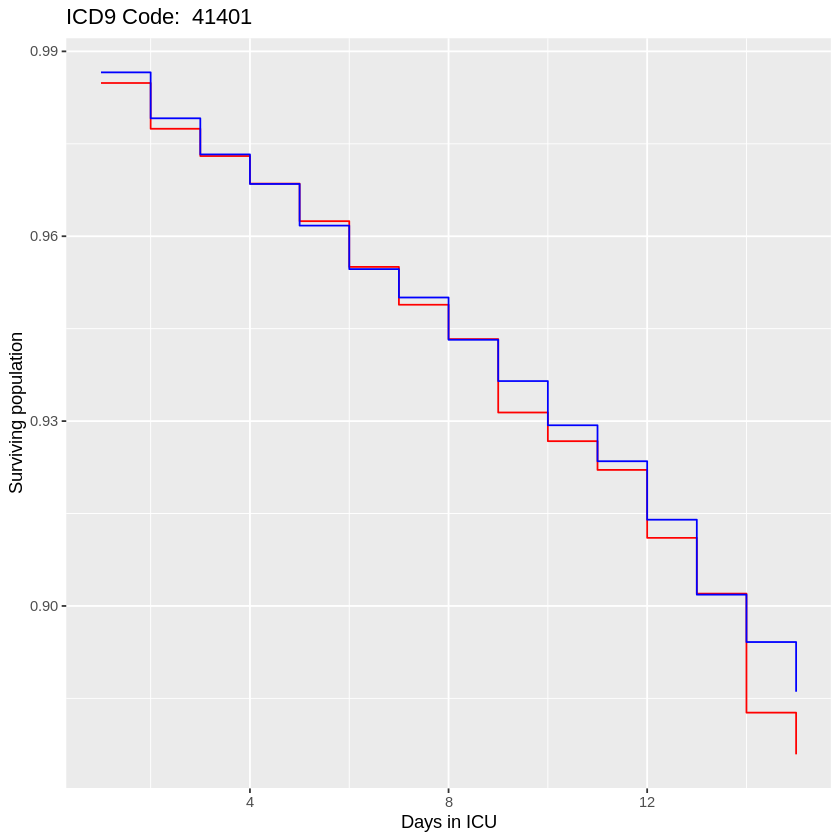

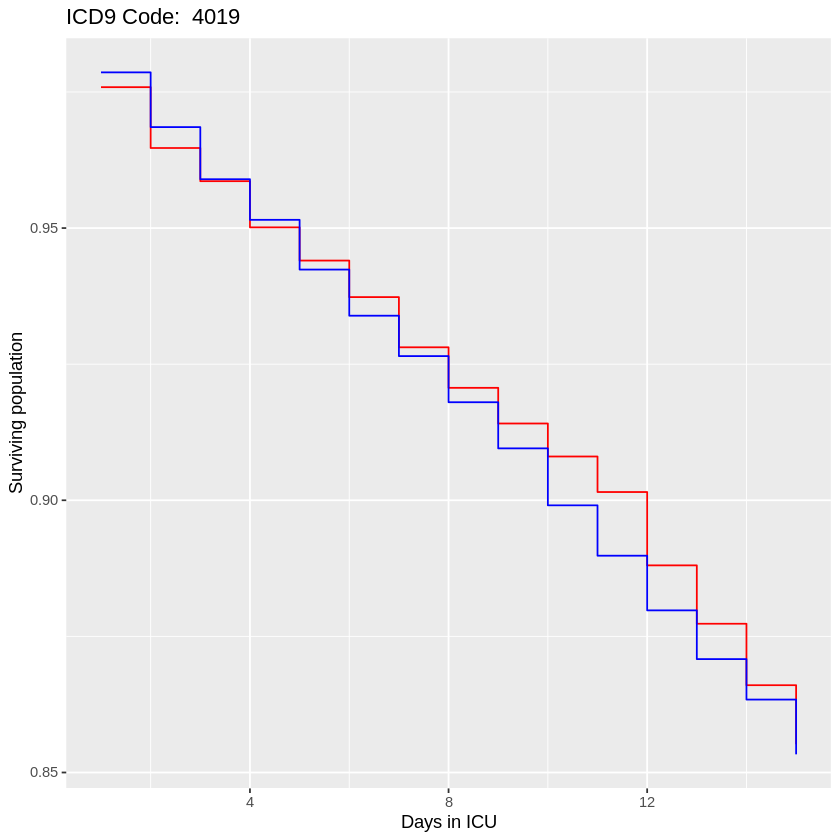

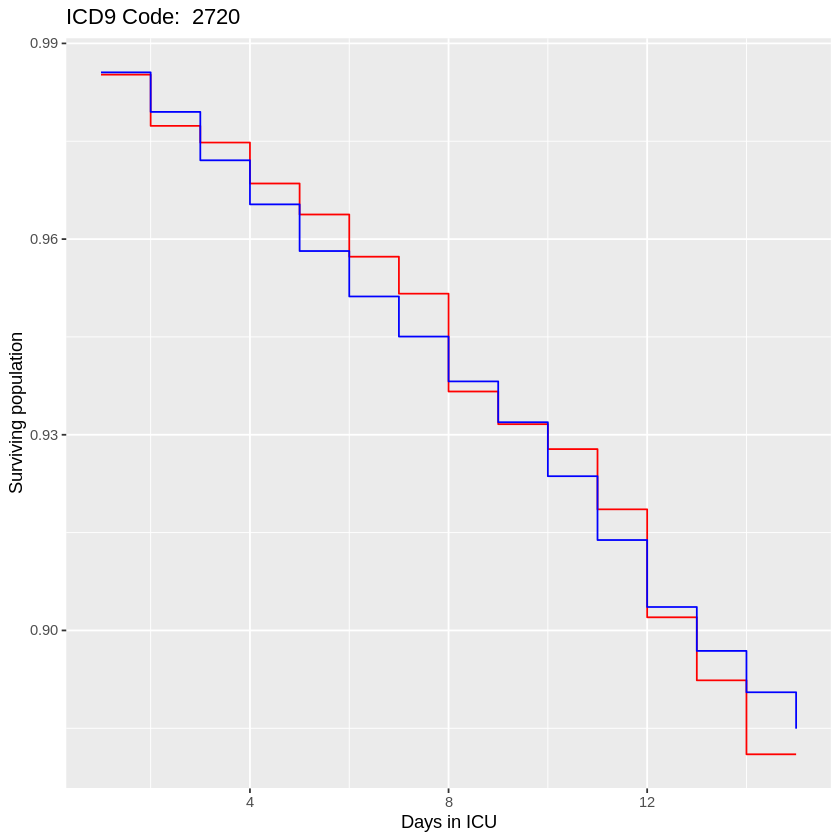

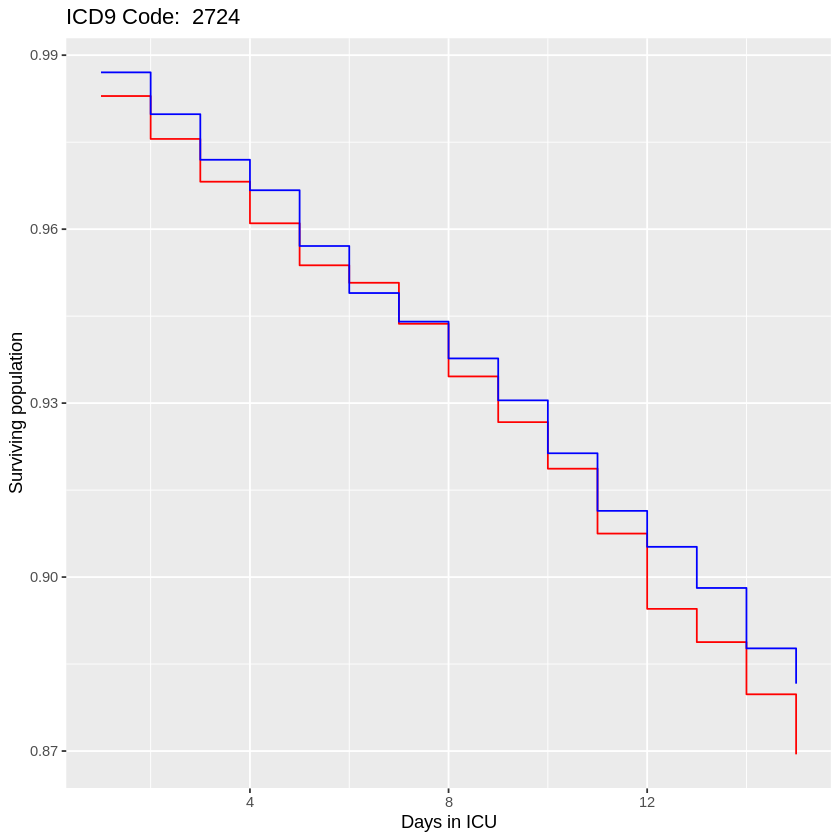

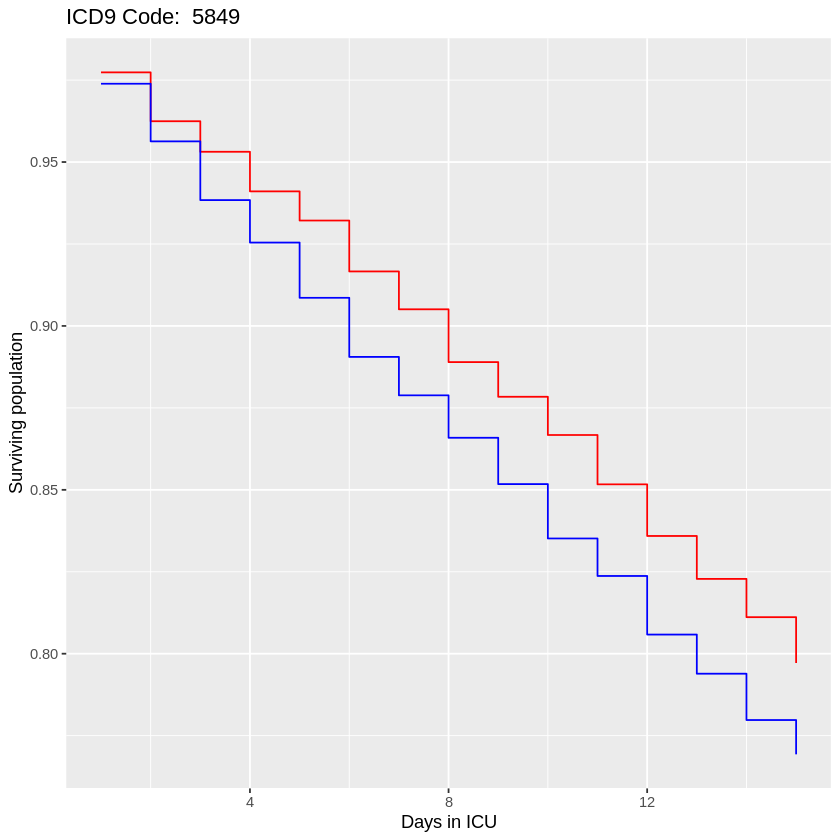

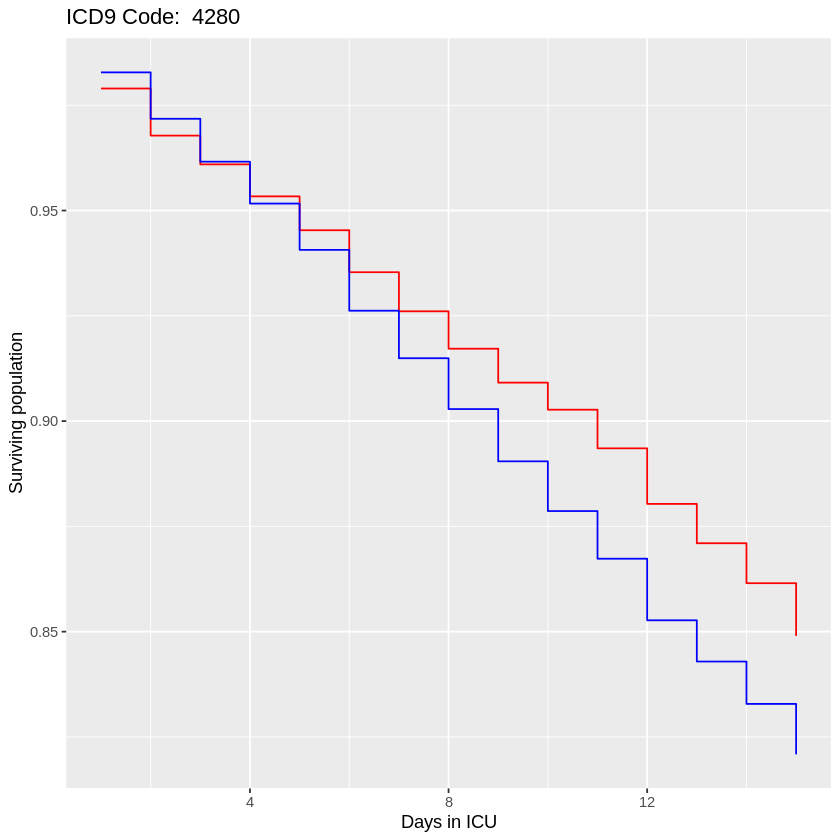

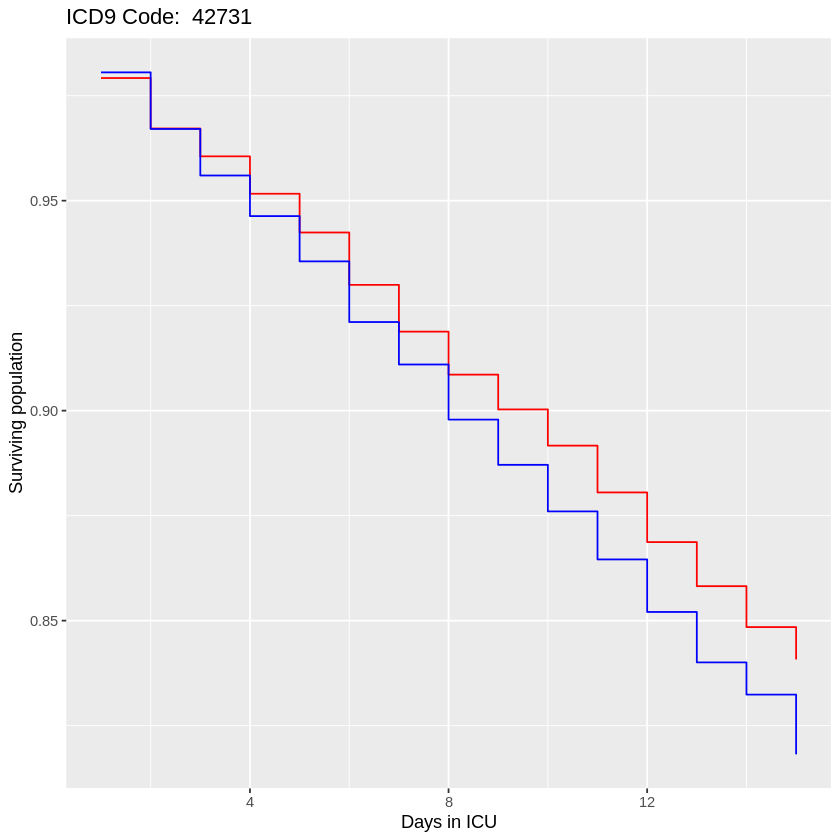

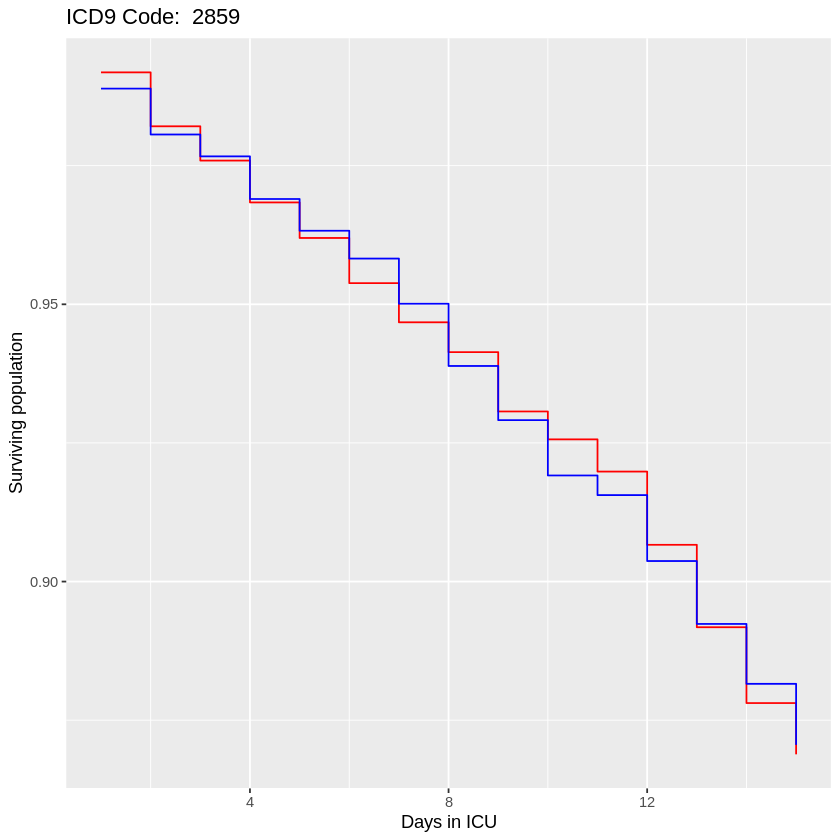

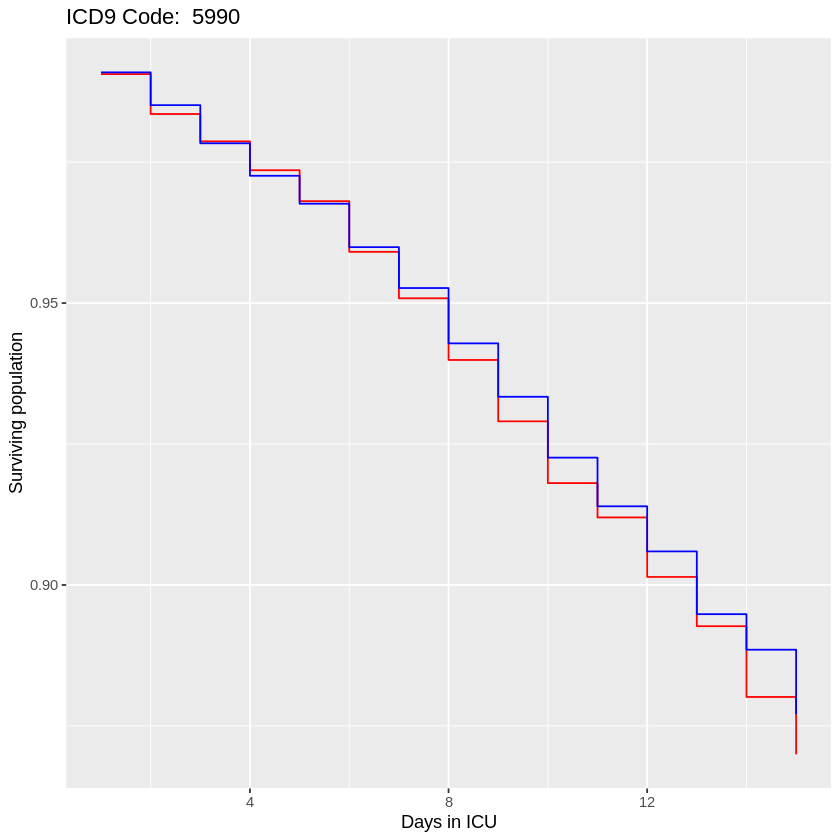

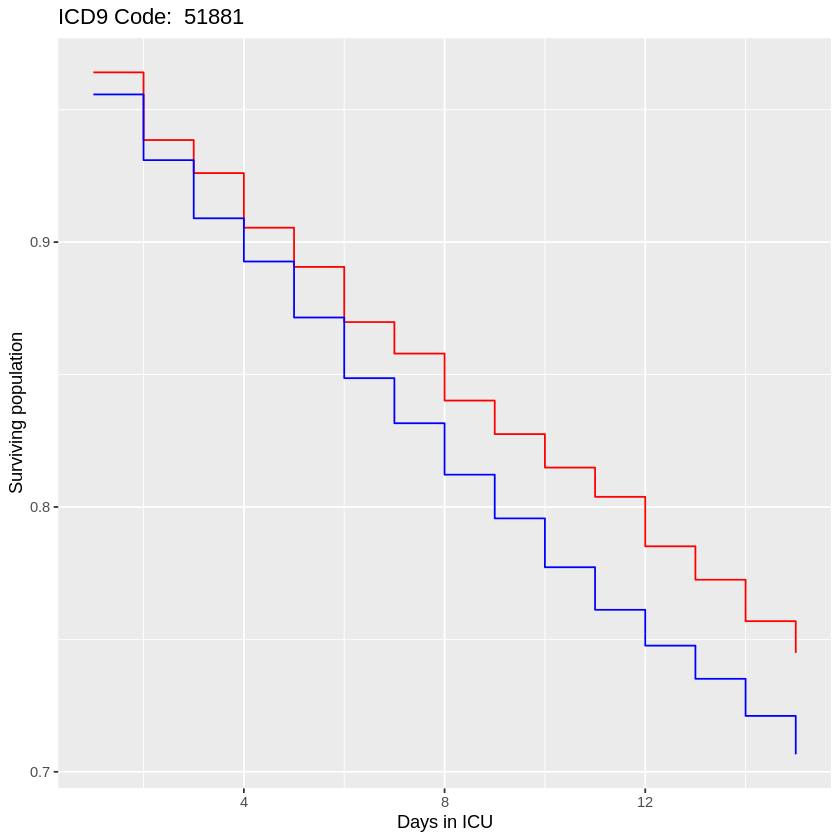

In [109]:
comorbidities <- unique(admissions$ICD9_CODE)
plot_KaplanMeier(comorbidities[1])
plot_KaplanMeier(comorbidities[2])
plot_KaplanMeier(comorbidities[3])
plot_KaplanMeier(comorbidities[4])
plot_KaplanMeier(comorbidities[5])
plot_KaplanMeier(comorbidities[6])
plot_KaplanMeier(comorbidities[7])
plot_KaplanMeier(comorbidities[8])
plot_KaplanMeier(comorbidities[9])
plot_KaplanMeier(comorbidities[10])
